In [1]:
%reload_ext autoreload
%autoreload 2

Ensure `plotly-orca` is installed.

In [2]:
%%capture
!pip install kaleido==0.1.0.post1

In [3]:
%%capture
!conda install -y plotly-orca -c plotly

### Imports

In [2]:
import os
from base64 import b64encode

import numpy as np
import pandas as pd
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
from plotly.subplots import  make_subplots
from IPython.display import display, SVG

Define the directories containing (i) the processed data and (ii) the processed results.

### Load modelling data

In [3]:
modelling_data_dir = '../analysis/modelling'

In [4]:
# Obtain data and format
data = pd.read_csv(os.path.join(modelling_data_dir, 'all_modelling_results.tsv.xz'), sep='\t')
data_counts = pd.read_csv(os.path.join(modelling_data_dir, 'all_modelling_counts.tsv.xz'), sep='\t')
data_counts['datapoints_mutant_percentage'] = data_counts.num_datapoints_mutants / data_counts.num_datapoints_total * 100
data_counts['datapoints_WT_percentage'] = 100 - data_counts.datapoints_mutant_percentage
data_counts['minority_percentage'] = data_counts[['datapoints_mutant_percentage', 'datapoints_WT_percentage']].min(axis=1)

In [5]:
# Add data counts and minority percentage
data_counts = data_counts.drop(columns='datapoints_mutant_percentage')

Get data counts for the common subsets

In [6]:
data_counts_common = (data[(data.subset == 'common') & (data.modeltype == 'PCM') & (data.crossval == 'random') & (~data.folds.isin(['Mean', 'SD'])) & data.contains_mutants]
                        .groupby('accession')
                        .agg({'number': 'sum'})
                        .sort_values('number', ascending=False)
                        .reset_index()
                        .rename(columns={'number': 'num_common_datapoints_total'})
)
data_counts_common_mutants = (data[(data.subset == 'common') & (data.modeltype == 'PCM') & (data.crossval == 'random') & (~data.folds.isin(['Mean', 'SD'])) & ~data.contains_mutants]
                        .groupby('accession')
                        .agg({'number': 'sum'})
                        .sort_values('number', ascending=False)
                        .reset_index()
                        .rename(columns={'number': 'num_common_datapoints_WT'})
)
data_counts_common = data_counts_common.merge(data_counts_common_mutants, on='accession', how='outer').fillna(0)
data_counts_common['num_common_datapoints_mutants'] = data_counts_common.num_common_datapoints_total - data_counts_common.num_common_datapoints_WT
data_counts_common['common_datapoints_WT_percentage'] = data_counts_common.num_common_datapoints_WT / data_counts_common.num_common_datapoints_total * 100
data_counts_common['minority_percentage'] = pd.DataFrame([data_counts_common.common_datapoints_WT_percentage, 100 - data_counts_common.common_datapoints_WT_percentage]).min(axis=0)
data_counts_common.to_csv(os.path.join(modelling_data_dir, 'common_modelling_counts.tsv.xz'), sep='\t', index=False)

In [7]:
# Obtain data of accessions modelled with QSAR and PCM on the complete set (random CV)
subplot1_data = (data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & data.contains_mutants]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]))
subplot1_data = subplot1_data.merge(data_counts, on='accession')

In [8]:
# Obtain data of accessions modelled with QSAR on the complete set both with and without mutants (random CV)
subplot2_data = (pd.concat([data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & (data.modeltype == 'QSAR') & data.contains_mutants],
                            data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & (data.modeltype == 'QSAR') & ~data.contains_mutants]])
                 .drop(columns=[col for col in data.columns if col not in ['Pearson r', 'accession', 'contains_mutants']]))
subplot2_data = subplot2_data.merge(data_counts, on='accession')
# Keep accessions that were modelled only with and without mutants
subplot2_data = (subplot2_data.groupby('accession')
                 .filter(lambda x: len(x['contains_mutants']) == 2))

In [9]:
# Obtain data of accessions modelled with QSAR and PCM on common subset (random CV)
subplot3_data = (pd.concat([data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'common') & (data.modeltype == 'PCM') & data.contains_mutants],
                            data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'common') & (data.modeltype == 'QSAR') & data.contains_mutants]])
                 .drop(columns=[col for col in data.columns if col not in ['Pearson r', 'accession', 'modeltype']]))
subplot3_data = subplot3_data.merge(data_counts_common, on='accession')
# Keep accessions that were modelled with mutants only
subplot3_data = (subplot3_data.groupby('accession')
                 .filter(lambda x: len(x['modeltype']) == 2))

In [10]:
# Obtain data of accessions modelled with QSAR and PCM on the complete set (random CV)
subplot4_data = (data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & ~data.contains_mutants]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]))
subplot4_data = (subplot4_data.merge(data_counts, on='accession'))

In [11]:
# Obtain 33rd and 66th percentiles
num_33_percentile = round(pd.concat([subplot1_data.num_datapoints_total, subplot2_data.num_datapoints_total]).quantile(1/3), 0)
num_33_percentile_common = subplot3_data.num_common_datapoints_total.quantile(1/3).round(0)
num_66_percentile = round(pd.concat([subplot1_data.num_datapoints_total, subplot2_data.num_datapoints_total, subplot3_data.num_common_datapoints_total]).quantile(2/3), 0)
num_66_percentile_common = subplot3_data.num_common_datapoints_total.quantile(2/3).round(0)
ratio_33_percentile = round(pd.concat([subplot1_data.minority_percentage, subplot2_data.minority_percentage]).quantile(1/3), 0)
ratio_33_percentile_common = subplot3_data.num_common_datapoints_total.quantile(1/3).round(0)
ratio_66_percentile = round(pd.concat([subplot1_data.minority_percentage, subplot2_data.minority_percentage]).quantile(2/3), 0)
ratio_66_percentile_common = subplot3_data.num_common_datapoints_total.quantile(2/3).round(0)

# Obtain X/9th percentiles
num_11_percentile = round(pd.concat([subplot1_data.num_datapoints_total, subplot2_data.num_datapoints_total]).quantile(1/9), 0)
num_22_percentile = round(pd.concat([subplot1_data.num_datapoints_total, subplot2_data.num_datapoints_total]).quantile(2/9), 0)
num_44_percentile = round(pd.concat([subplot1_data.num_datapoints_total, subplot2_data.num_datapoints_total]).quantile(4/9), 0)
num_55_percentile = round(pd.concat([subplot1_data.num_datapoints_total, subplot2_data.num_datapoints_total]).quantile(5/9), 0)
num_77_percentile = round(pd.concat([subplot1_data.num_datapoints_total, subplot2_data.num_datapoints_total, subplot3_data.num_common_datapoints_total]).quantile(7/9), 0)
num_88_percentile = round(pd.concat([subplot1_data.num_datapoints_total, subplot2_data.num_datapoints_total]).quantile(8/9), 0)
num_11_percentile_common = subplot3_data.num_common_datapoints_total.quantile(1/9).round(0)
num_22_percentile_common = subplot3_data.num_common_datapoints_total.quantile(2/9).round(0)
num_44_percentile_common = subplot3_data.num_common_datapoints_total.quantile(4/9).round(0)
num_55_percentile_common = subplot3_data.num_common_datapoints_total.quantile(6/9).round(0)
num_77_percentile_common = subplot3_data.num_common_datapoints_total.quantile(7/9).round(0)
num_88_percentile_common = subplot3_data.num_common_datapoints_total.quantile(8/9).round(0)


ratio_11_percentile = round(pd.concat([subplot1_data.minority_percentage, subplot2_data.minority_percentage]).quantile(1/9), 0)
ratio_22_percentile = round(pd.concat([subplot1_data.minority_percentage, subplot2_data.minority_percentage]).quantile(2/9), 0)
ratio_44_percentile = round(pd.concat([subplot1_data.minority_percentage, subplot2_data.minority_percentage]).quantile(4/9), 0)
ratio_55_percentile = round(pd.concat([subplot1_data.minority_percentage, subplot2_data.minority_percentage]).quantile(5/9), 0)
ratio_77_percentile = round(pd.concat([subplot1_data.minority_percentage, subplot2_data.minority_percentage]).quantile(7/9), 0)
ratio_88_percentile = round(pd.concat([subplot1_data.minority_percentage, subplot2_data.minority_percentage]).quantile(8/9), 0)

ratio_11_percentile_common = subplot3_data.minority_percentage.quantile(1/9).round(0)
ratio_22_percentile_common = subplot3_data.minority_percentage.quantile(2/9).round(0)
ratio_44_percentile_common = subplot3_data.minority_percentage.quantile(4/9).round(0)
ratio_55_percentile_common = subplot3_data.minority_percentage.quantile(5/9).round(0)
ratio_77_percentile_common = subplot3_data.minority_percentage.quantile(7/9).round(0)
ratio_88_percentile_common = subplot3_data.minority_percentage.quantile(8/9).round(0)

In [12]:
app = Dash(__name__)

app.layout = html.Div([
                       dcc.Graph(id="heatmap-graph"),
                       html.P("#datapoints:"),
                       dcc.RangeSlider(
                           id='heatmap-x-range-slider',
                           min=subplot1_data.num_datapoints_total.min(),
                           max=subplot1_data.num_datapoints_total.max(),
                           step=1000,
                           value=[subplot1_data.num_datapoints_total.min(), 1_000, 10_000, subplot1_data.num_datapoints_total.max()]
                           ),
                       html.P("balance ratio:"),
                       dcc.RangeSlider(
                            id='heatmap-y-range-slider',
                            min=0, max=50, step=1,
                            value=[0, 15, 30, 50]
                            ),
                       html.P("zmax:"),
                       dcc.Slider(
                            id='heatmap-zmax-slider',
                            min=0, max=1, step=0.1,
                            value=1.0
                            ),
                       html.P("num datapoints (common)"),
                       dcc.RangeSlider(
                            id='heatmap-binscommon-slider',
                            min=subplot3_data.num_common_datapoints_total.min(),
                            max=subplot3_data.num_common_datapoints_total.max(),
                            step=10,
                            value=[subplot3_data.num_common_datapoints_total.min(), 100, 500, subplot3_data.num_common_datapoints_total.max()]
                            ),
                       html.P("balance ratio (common)"),
                       dcc.RangeSlider(
                            id='heatmap-balancecommon-slider',
                            min=0, max=50, step=1,
                            value=[0, 15, 30, 50]
                            ),
                       ])

@app.callback(
    Output("heatmap-graph", "figure"),
    [Input("heatmap-x-range-slider", "value"),
     Input("heatmap-y-range-slider", "value"),
     Input("heatmap-binscommon-slider", "value"),
     Input("heatmap-balancecommon-slider", "value"),
     Input("heatmap-zmax-slider", "value"),
     ])
def update_diff_bar_chart(slider_x, slider_y, slider_x_common, slider_y_common, slider_zmax=1):
    # Obtain data
    global subplot1_data, subplot2_data, subplot3_data
    subplot_data1 = subplot1_data.copy().drop(columns='accession')
    subplot_data2 = subplot2_data.copy().drop(columns='accession')
    subplot_data3 = subplot3_data.copy().drop(columns='accession')
    # Slider values
    min_x, low_x, high_x, max_x = slider_x
    min_y, low_y, high_y, max_y = slider_y
    
    min_x_common, low_x_common, high_x_common, max_x_common = slider_x_common
    min_y_common, low_y_common, high_y_common, max_y_common = slider_y_common
    
    # Obtain categories
    intervals_num_datapoints = [(min_x - 0.1, low_x),
                            (low_x, high_x),
                            (high_x, max_x)]
    intervals_ratio = [(min_y - 0.1, low_y),
                       (low_y, high_y),
                       (high_y, max_y)]
    
    intervals_num_datapoints_common = [(min_x_common - 0.1, low_x_common),
                            (low_x_common, high_x_common),
                            (high_x_common, max_x_common)]
    intervals_ratio_common = [(min_y_common - 0.1, low_y_common),
                       (low_y_common, high_y_common),
                       (high_y_common, max_y_common)]
    
    num_intervals = pd.IntervalIndex.from_tuples(intervals_num_datapoints)
    ratio_intervals = pd.IntervalIndex.from_tuples(intervals_ratio)
    
    num_intervals_common = pd.IntervalIndex.from_tuples(intervals_num_datapoints_common)
    ratio_intervals_common = pd.IntervalIndex.from_tuples(intervals_ratio_common)

    # Put data in bins
    subplot_data1['num_bins'] = pd.cut(subplot_data1.num_datapoints_total.values, num_intervals)
    subplot_data2['num_bins'] = pd.cut(subplot_data2.num_datapoints_total.values, num_intervals)
    subplot_data3['num_bins'] = pd.cut(subplot_data3.num_common_datapoints_total.values, num_intervals_common)
    subplot_data1['ratio_bins'] = pd.cut(subplot_data1.minority_percentage.values, ratio_intervals)
    subplot_data2['ratio_bins'] = pd.cut(subplot_data2.minority_percentage.values, ratio_intervals)
    subplot_data3['ratio_bins'] = pd.cut(subplot_data3.minority_percentage.values, ratio_intervals_common)
    
    # Rename intervals
    subplot_data1['num_bins'] = subplot_data1['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data2['num_bins'] = subplot_data2['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data3['num_bins'] = subplot_data3['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    # Clean up columns
    subplot_data1 = subplot_data1.drop(columns=['num_datapoints_total', 'minority_percentage'])
    subplot_data2 = subplot_data2.drop(columns=['num_datapoints_total', 'minority_percentage'])
    subplot_data3 = subplot_data3.drop(columns=['num_common_datapoints_total', 'minority_percentage'])
    
    # Remove nan bins
    subplot_data1 = subplot_data1[subplot_data1.num_bins != 'nan']
    subplot_data2 = subplot_data2[subplot_data2.num_bins != 'nan']
    subplot_data3 = subplot_data3[subplot_data3.num_bins != 'nan']
    
    # Group by, pivot and obtain difference
    subplot_data1 = subplot_data1.groupby(['modeltype', 'num_bins', 'ratio_bins']).agg('mean').reset_index()
    subplot_data1 = subplot_data1.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['modeltype', 'ratio_bins']).reset_index()
    subplot_data1.iloc[np.where(subplot_data1.modeltype == 'QSAR')[0], 2:] = -subplot_data1.iloc[np.where(subplot_data1.modeltype == 'QSAR')[0], 2:]
    subplot_data1 = subplot_data1.drop(columns='modeltype').groupby('ratio_bins').agg('sum')
    # subplot_data1
    
    subplot_data2 = subplot_data2.groupby(['contains_mutants', 'num_bins', 'ratio_bins']).agg('mean').reset_index()
    subplot_data2 = subplot_data2.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['contains_mutants', 'ratio_bins']).reset_index()
    subplot_data2.iloc[np.where(~subplot_data2.contains_mutants)[0], 2:] = -subplot_data2.iloc[np.where(~subplot_data2.contains_mutants)[0], 2:]
    subplot_data2 = subplot_data2.drop(columns='contains_mutants').groupby('ratio_bins').agg('sum')
    # subplot_data2
    
    subplot_data3 = subplot_data3.groupby(['modeltype', 'num_bins', 'ratio_bins']).agg('mean').reset_index()
    subplot_data3 = subplot_data3.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['modeltype', 'ratio_bins']).reset_index()
    subplot_data3.iloc[np.where(subplot_data3.modeltype == 'QSAR')[0], 2:] = -subplot_data3.iloc[np.where(subplot_data3.modeltype == 'QSAR')[0], 2:]
    subplot_data3 = subplot_data3.drop(columns='modeltype').groupby('ratio_bins').agg('sum')
    # Melt dataframes 
    subplot_data1 = pd.melt(subplot_data1.reset_index(), id_vars=['ratio_bins']) 
    subplot_data2 = pd.melt(subplot_data2.reset_index(), id_vars=['ratio_bins'])
    subplot_data3 = pd.melt(subplot_data3.reset_index(), id_vars=['ratio_bins'])

    # Determine bins without values
    # empty_ratio_bins = 
        
    
    # Rename intervals
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[0]): f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]'})
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[1]): f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]'})
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[2]): f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'[{intervals_ratio[0][0]:.0f}, {intervals_ratio[0][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[1][0]:.0f}, {intervals_ratio[1][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[2][0]:.0f}, {intervals_ratio[2][1]:.0f}]'})
    
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[0]): f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]'})
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[1]): f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]'})
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[2]): f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'[{intervals_ratio[0][0]:.0f}, {intervals_ratio[0][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[1][0]:.0f}, {intervals_ratio[1][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[2][0]:.0f}, {intervals_ratio[2][1]:.0f}]'})
    
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals_common[0]): f'[{intervals_num_datapoints_common[0][0] + 0.1:.0f}, {intervals_num_datapoints_common[1][0]:.0f}]'})
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals_common[1]): f'({intervals_num_datapoints_common[1][0]:.0f}, {intervals_num_datapoints_common[1][1]:.0f}]'})
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals_common[2]): f'({intervals_num_datapoints_common[2][0]:.0f}, {intervals_num_datapoints_common[2][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals_common[0]): f'[{intervals_ratio_common[0][0]:.0f}, {intervals_ratio_common[0][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals_common[0]): f'({intervals_ratio_common[1][0]:.0f}, {intervals_ratio_common[1][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals_common[0]): f'({intervals_ratio_common[2][0]:.0f}, {intervals_ratio_common[2][1]:.0f}]'})
    
    # Determine zmax for colorbar
    zmax = max((subplot_data1.value.max(),
                subplot_data2.value.max(),
                subplot_data3.value.max()))
    
    # Figure
    fig = make_subplots(rows=1, cols=3,
                        shared_yaxes=True,
                        subplot_titles=['PCM complete - QSAR complete', 'QSAR complete - QSAR no mutant', 'PCM common - QSAR common'],
                       )
    
    fig.add_trace(go.Heatmap(x=subplot_data1.num_bins, y=subplot_data1.ratio_bins, z=subplot_data1.value, 
                             zmin=0, zmax=slider_zmax,
                             showscale=False,
                             colorscale='RdYlGn',
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Heatmap(x=subplot_data2.num_bins, y=subplot_data2.ratio_bins, z=subplot_data2.value,
                             zmin=0, zmax=slider_zmax,
                             showscale=False,
                             colorscale='RdYlGn',
                             ),
                  row=1, col=2)
    
    fig.add_trace(go.Heatmap(x=subplot_data3.num_bins, y=subplot_data3.ratio_bins, z=subplot_data3.value,
                             zmin=0, zmax=slider_zmax,
                             colorscale='RdYlGn',
                             colorbar={"title": 'd(Pearson r)'}
                             ),
                  row=1, col=3)
    # Add title
    fig.update_layout({'xaxis': {'categoryarray': [f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'xaxis2': {'categoryarray': [f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'xaxis3': {'categoryarray': [f'[{intervals_num_datapoints_common[0][0] + 0.1:.0f}, {intervals_num_datapoints_common[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints_common[1][0]:.0f}, {intervals_num_datapoints_common[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints_common[2][0]:.0f}, {intervals_num_datapoints_common[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'yaxis': {'title': 'Minority class (WT/mutant) %'},
                       })

    fig.update_traces(row=1, col=1, text=subplot_data1.value, texttemplate="%{text:.3f}", hovertemplate=None)
    fig.update_traces(row=1, col=2, text=subplot_data2.value, texttemplate="%{text:.3f}", hovertemplate=None)
    fig.update_traces(row=1, col=3, text=subplot_data3.value, texttemplate="%{text:.3f}", hovertemplate=None)

    fig.update_layout(autosize=False, width=1050, height=430)

        
    return fig

if __name__ == '__main__':
    app.run_server(debug=False)

Export heatmaps to SVG 

In [13]:
USE_PERCENTILE = True

In [14]:
if not os.path.exists(os.path.join(modelling_data_dir, 'heatmaps')):
    os.makedirs(os.path.join(os.path.join(modelling_data_dir, 'heatmaps')), exist_ok=True)

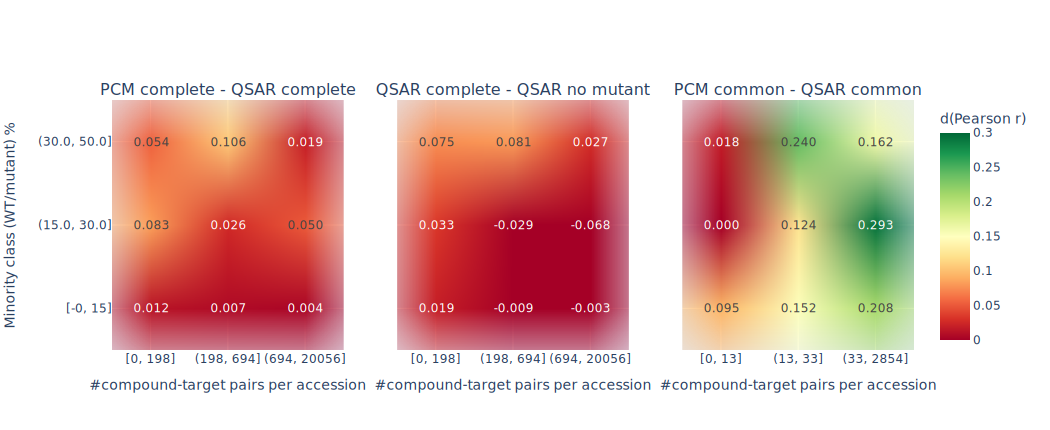

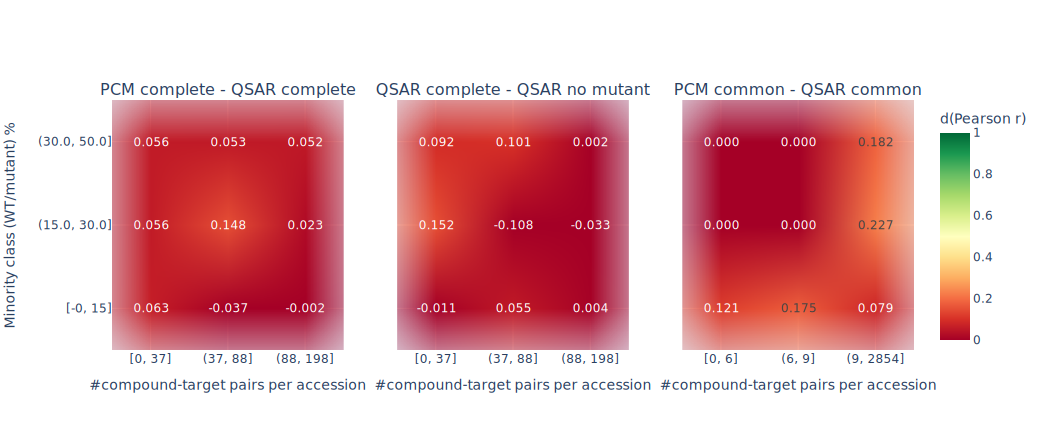

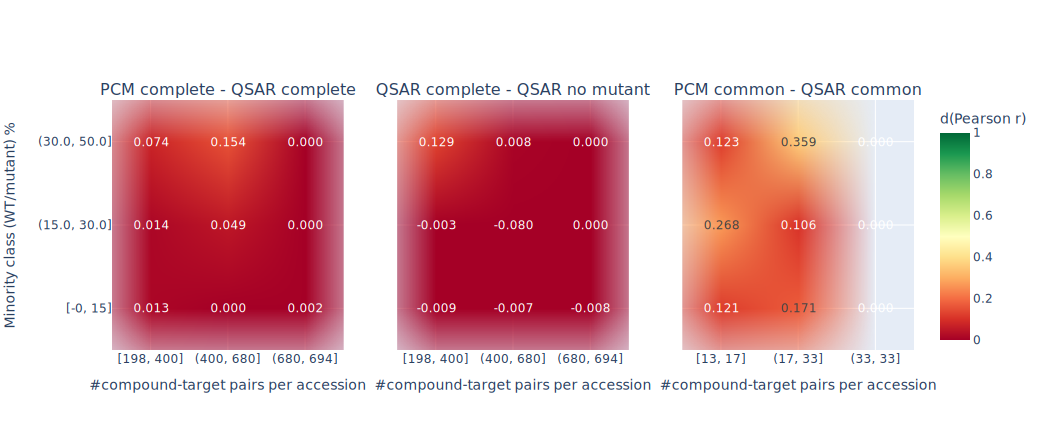

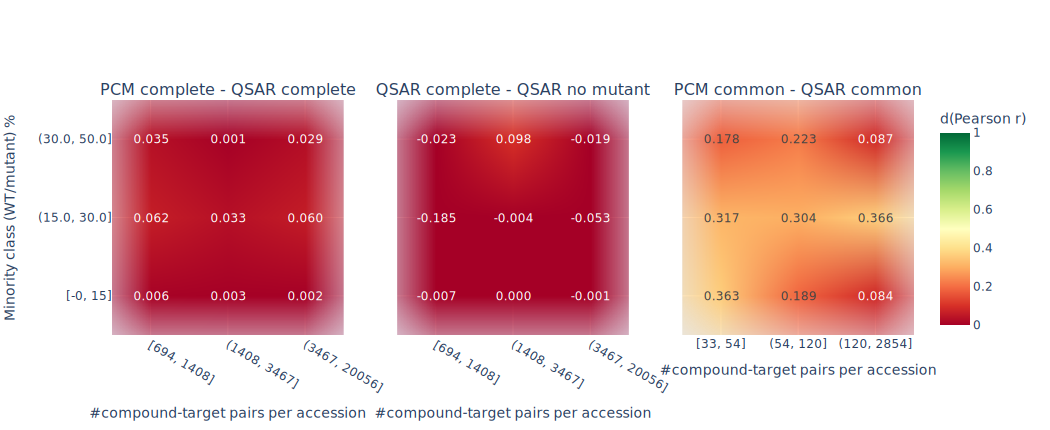

In [78]:
if USE_PERCENTILE:
    #Nums  = [0, 33.34%], (33.34%, 66.67%], (66.67%, 100.0%]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_diff_bar_chart((0, num_33_percentile, num_66_percentile, 20056), (0, 15, 30, 50),
                          (0, num_33_percentile_common, num_66_percentile_common, 2854), (0, 15, 30, 50), 0.3
                 ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapspercentiles.svg'), engine='orca')
    #Nums  = [0, 11.12%], (11.12%, 22.23%], (22.23%, 33.34%]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_diff_bar_chart((0, num_11_percentile, num_22_percentile, num_33_percentile), (0, 15, 30, 50),
                          (0, num_11_percentile_common, num_22_percentile_common, 2854), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapspercentiles_0-33-zoomin.svg'), engine='orca')
    #Nums  = [33.34, 44.45%], (44.45%, 55.56%], (55.56%, 66.67%]
    #Ratios= [0, 16.67%],     (16,67%, 33.34%], (33.34%, 50.0%]
    update_diff_bar_chart((num_33_percentile, num_44_percentile, num_55_percentile, num_66_percentile), (0, 15, 30, 50),
                          (num_33_percentile_common, num_44_percentile_common, num_55_percentile_common, num_66_percentile_common), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapspercentiles_33-66-zoomin.svg'), engine='orca') 
    #Nums  = [66.67, 77.78%], (77.78%, 88.89%], (88.89%, 100.0%]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_diff_bar_chart((num_66_percentile, num_77_percentile, num_88_percentile, 20056), (0, 15, 30, 50),
                          (num_66_percentile_common, num_77_percentile_common, num_88_percentile_common, 2854), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapspercentiles_66-100-zoomin.svg'), engine='orca')
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapspercentiles.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapspercentiles_0-33-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapspercentiles_33-66-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapspercentiles_66-100-zoomin.svg')))
else:
    #Nums  = [0, 1_000],  (1_000, 10_000],  (10_000, 75_211]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_diff_bar_chart((0, 1_000, 10_000, 20056), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50), 0.3
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapsnum-0-20k_no-zmax.svg'), engine='orca')
    #Nums  = [0, 1_000],  (1_000, 10_000],  (10_000, 75_211]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_diff_bar_chart((0, 1_000, 10_000, 20056), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapsnum-0-20k.svg'), engine='orca')
    #Nums  = [0, 100],    (100, 500],       (500, 1_000]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_diff_bar_chart((0, 100, 500, 1000), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapsnum-0k-1k-zoomin.svg'), engine='orca')
    #Nums  = [1_000, 2_000],  (2_000, 5_000],  (5_000, 10_000]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_diff_bar_chart((1_000, 2_000, 5_000, 10_000), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapsnum-1k-10k-zoomin.svg'), engine='orca')
    #Nums  = [10_000, 15_000],  (15_000, 50_000],  (50_000, 75_211]
    #Ratios= [0, 16.67%],       (16,67%, 33.34%],  (33.34%, 50.0%]
    update_diff_bar_chart((10_000, 14000, 18000, 20056), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapsnum-10k-20k-zoomin.svg'), engine='orca')
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapsnum-0-20k_no-zmax.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapsnum-0-20k.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapsnum-0k-1k-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapsnum-1k-10k-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_diff_heatmapsnum-10k-20k-zoomin.svg')))

In [16]:
app = Dash(__name__)

app.layout = html.Div([
                       dcc.Graph(id="heatmap-graph"),
                       html.P("#datapoints:"),
                       dcc.RangeSlider(
                           id='heatmap-x-range-slider',
                           min=subplot1_data.num_datapoints_total.min(),
                           max=subplot1_data.num_datapoints_total.max(),
                           step=1000,
                           value=[subplot1_data.num_datapoints_total.min(), 1_000, 10_000, subplot1_data.num_datapoints_total.max()]
                           ),
                       html.P("balance ratio:"),
                       dcc.RangeSlider(
                            id='heatmap-y-range-slider',
                            min=0, max=50, step=1,
                           value=[0, 15, 30, 50]
                            ),
                       html.P("zmin-zmax:"),
                       dcc.RangeSlider(
                            id='heatmap-zmax-slider',
                            min=0, max=1, step=0.1,
                           value=[0.5, 1.0]
                            ),
                       html.P("num datapoints (common)"),
                       dcc.RangeSlider(
                            id='heatmap-binscommon-slider',
                            min=subplot3_data.num_common_datapoints_total.min(),
                            max=subplot3_data.num_common_datapoints_total.max(),
                            step=10,
                            value=[subplot3_data.num_common_datapoints_total.min(), 100, 500, subplot3_data.num_common_datapoints_total.max()]
                            ),
                       html.P("balance ratio (common)"),
                       dcc.RangeSlider(
                            id='heatmap-balancecommon-slider',
                            min=0, max=50, step=1,
                            value=[0, 15, 30, 50]
                            ),
                       ])


@app.callback(
    Output("heatmap-graph", "figure"),
    [Input("heatmap-x-range-slider", "value"),
     Input("heatmap-y-range-slider", "value"),
     Input("heatmap-binscommon-slider", "value"),
     Input("heatmap-balancecommon-slider", "value"),
     Input("heatmap-zmax-slider", "value"),])
def update_avg_bar_chart(slider_x, slider_y, slider_x_common, slider_y_common, slider_zmax=(0, 1)):
    # Obtain data
    global subplot1_data, subplot3_data, subplot4_data
    subplot_data1 = subplot1_data.copy().drop(columns='accession')
    subplot_data2 = subplot4_data.copy().drop(columns='accession')
    subplot_data3 = subplot3_data.copy().drop(columns='accession')
    # Slider values
    min_x, low_x, high_x, max_x = slider_x
    min_y, low_y, high_y, max_y = slider_y
    
    min_x_common, low_x_common, high_x_common, max_x_common = slider_x_common
    min_y_common, low_y_common, high_y_common, max_y_common = slider_y_common
       
    # Obtain categories
    intervals_num_datapoints = [(min_x - 0.1, low_x),
                            (low_x, high_x),
                            (high_x, max_x)]
    intervals_ratio = [(min_y - 0.1, low_y),
                       (low_y, high_y),
                       (high_y, max_y)]
    
    intervals_num_datapoints_common = [(min_x_common - 0.1, low_x_common),
                            (low_x_common, high_x_common),
                            (high_x_common, max_x_common)]
    intervals_ratio_common = [(min_y_common - 0.1, low_y_common),
                       (low_y_common, high_y_common),
                       (high_y_common, max_y_common)]
    
    num_intervals = pd.IntervalIndex.from_tuples(intervals_num_datapoints)
    ratio_intervals = pd.IntervalIndex.from_tuples(intervals_ratio)
    
    num_intervals_common = pd.IntervalIndex.from_tuples(intervals_num_datapoints_common)
    ratio_intervals_common = pd.IntervalIndex.from_tuples(intervals_ratio_common)
    
    # Put data in bins
    subplot_data1['num_bins'] = pd.cut(subplot_data1.num_datapoints_total.values, num_intervals)
    subplot_data2['num_bins'] = pd.cut(subplot_data2.num_datapoints_total.values, num_intervals)
    subplot_data3['num_bins'] = pd.cut(subplot_data3.num_common_datapoints_total.values, num_intervals_common)
    subplot_data1['ratio_bins'] = pd.cut(subplot_data1.minority_percentage.values, ratio_intervals)
    subplot_data2['ratio_bins'] = pd.cut(subplot_data2.minority_percentage.values, ratio_intervals)
    subplot_data3['ratio_bins'] = pd.cut(subplot_data3.minority_percentage.values, ratio_intervals_common)
    
    # Rename intervals
    subplot_data1['num_bins'] = subplot_data1['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data2['num_bins'] = subplot_data2['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data3['num_bins'] = subplot_data3['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    # Clean up columns
    subplot_data1 = subplot_data1.drop(columns=['num_datapoints_total', 'minority_percentage'])
    subplot_data2 = subplot_data2.drop(columns=['num_datapoints_total', 'minority_percentage'])
    subplot_data3 = subplot_data3.drop(columns=['num_common_datapoints_total', 'minority_percentage'])
    
    # Remove nan bins
    subplot_data1 = subplot_data1[subplot_data1.num_bins != 'nan']
    subplot_data2 = subplot_data2[subplot_data2.num_bins != 'nan']
    subplot_data3 = subplot_data3[subplot_data3.num_bins != 'nan']
    
    # Group by, pivot and obtain difference
    subplot_data1 = subplot_data1.groupby(['modeltype', 'num_bins', 'ratio_bins']).agg('mean').reset_index()
    subplot_data1 = subplot_data1.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['modeltype', 'ratio_bins']).reset_index()
    subplot_data1 = subplot_data1.drop(columns='modeltype').groupby('ratio_bins').agg('mean')
    # subplot_data1
    
    subplot_data2 = subplot_data2.groupby(['modeltype', 'num_bins', 'ratio_bins']).agg('mean').reset_index()
    subplot_data2 = subplot_data2.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['modeltype', 'ratio_bins']).reset_index()
    subplot_data2 = subplot_data2.drop(columns='modeltype').groupby('ratio_bins').agg('mean')
    # subplot_data2
    
    subplot_data3 = subplot_data3.groupby(['modeltype', 'num_bins', 'ratio_bins']).agg('mean').reset_index()
    subplot_data3 = subplot_data3.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['modeltype', 'ratio_bins']).reset_index()
    subplot_data3 = subplot_data3.drop(columns='modeltype').groupby('ratio_bins').agg('mean')
    # Melt dataframes 
    subplot_data1 = pd.melt(subplot_data1.reset_index(), id_vars=['ratio_bins']) 
    subplot_data2 = pd.melt(subplot_data2.reset_index(), id_vars=['ratio_bins'])
    subplot_data3 = pd.melt(subplot_data3.reset_index(), id_vars=['ratio_bins'])

    # Determine bins without values
    # empty_ratio_bins = 
        
    
    # Rename intervals
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[0]): f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]'})
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[1]): f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]'})
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[2]): f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'[{intervals_ratio[0][0]:.0f}, {intervals_ratio[0][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[1][0]:.0f}, {intervals_ratio[1][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[2][0]:.0f}, {intervals_ratio[2][1]:.0f}]'})
    
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[0]): f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]'})
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[1]): f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]'})
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[2]): f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'[{intervals_ratio[0][0]:.0f}, {intervals_ratio[0][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[1][0]:.0f}, {intervals_ratio[1][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[2][0]:.0f}, {intervals_ratio[2][1]:.0f}]'})
    
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals_common[0]): f'[{intervals_num_datapoints_common[0][0] + 0.1:.0f}, {intervals_num_datapoints_common[1][0]:.0f}]'})
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals_common[1]): f'({intervals_num_datapoints_common[1][0]:.0f}, {intervals_num_datapoints_common[1][1]:.0f}]'})
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals_common[2]): f'({intervals_num_datapoints_common[2][0]:.0f}, {intervals_num_datapoints_common[2][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals_common[0]): f'[{intervals_ratio_common[0][0]:.0f}, {intervals_ratio_common[0][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals_common[0]): f'({intervals_ratio_common[1][0]:.0f}, {intervals_ratio_common[1][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals_common[0]): f'({intervals_ratio_common[2][0]:.0f}, {intervals_ratio_common[2][1]:.0f}]'})
    
    # Determine zmax for colorbar
    zmax = max((subplot_data1.value.max(),
                subplot_data2.value.max(),
                subplot_data3.value.max()))
    
    # Figure
    fig = make_subplots(rows=1, cols=3,
                        shared_yaxes=True,
                        subplot_titles=['complete dataset', 'no mutant', 'common subset'],
                       )
    
    fig.add_trace(go.Heatmap(x=subplot_data1.num_bins, y=subplot_data1.ratio_bins, z=subplot_data1.value, 
                             zmin=slider_zmax[0], zmax=slider_zmax[1],
                             showscale=False,
                             colorscale='RdYlGn',
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Heatmap(x=subplot_data2.num_bins, y=subplot_data2.ratio_bins, z=subplot_data2.value,
                             zmin=slider_zmax[0], zmax=slider_zmax[1],
                             showscale=False,
                             colorscale='RdYlGn',
                             ),
                  row=1, col=2)
    
    fig.add_trace(go.Heatmap(x=subplot_data3.num_bins, y=subplot_data3.ratio_bins, z=subplot_data3.value,
                             zmin=slider_zmax[0], zmax=slider_zmax[1],
                             colorscale='RdYlGn',
                             colorbar={"title": 'Pearson r'}
                             ),
                  row=1, col=3)
    # Add title
    fig.update_layout({'xaxis': {'categoryarray': [f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'xaxis2': {'categoryarray': [f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'xaxis3': {'categoryarray': [f'[{intervals_num_datapoints_common[0][0] + 0.1:.0f}, {intervals_num_datapoints_common[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints_common[1][0]:.0f}, {intervals_num_datapoints_common[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints_common[2][0]:.0f}, {intervals_num_datapoints_common[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'yaxis': {'title': 'Minority class (WT/mutant) %'},
                       })

    fig.update_traces(row=1, col=1, text=subplot_data1.value, texttemplate="%{text:.3f}", hovertemplate=None)
    fig.update_traces(row=1, col=2, text=subplot_data2.value, texttemplate="%{text:.3f}", hovertemplate=None)
    fig.update_traces(row=1, col=3, text=subplot_data3.value, texttemplate="%{text:.3f}", hovertemplate=None)

    fig.update_layout(autosize=False, width=1050, height=430)

        
    return fig

if __name__ == '__main__':
    app.run_server(debug=False)

In [79]:
subplot3_data.num_common_datapoints_total.quantile([i/100 for i in range(101)]).to_dict()

{0.0: 5.0,
 0.01: 5.0,
 0.02: 5.0,
 0.03: 6.0,
 0.04: 6.0,
 0.05: 6.0,
 0.06: 6.0,
 0.07: 6.0,
 0.08: 6.0,
 0.09: 6.0,
 0.1: 6.0,
 0.11: 6.0,
 0.12: 6.0,
 0.13: 7.0,
 0.14: 7.0,
 0.15: 7.0,
 0.16: 8.0,
 0.17: 8.0,
 0.18: 8.0,
 0.19: 8.0,
 0.2: 8.0,
 0.21: 8.0,
 0.22: 9.0,
 0.23: 9.590000000000003,
 0.24: 10.0,
 0.25: 10.0,
 0.26: 10.0,
 0.27: 11.0,
 0.28: 11.0,
 0.29: 11.569999999999993,
 0.3: 12.0,
 0.31: 12.0,
 0.32: 12.0,
 0.33: 13.0,
 0.34: 13.219999999999999,
 0.35: 14.0,
 0.36: 14.0,
 0.37: 14.0,
 0.38: 15.0,
 0.39: 15.0,
 0.4: 15.0,
 0.41: 16.0,
 0.42: 16.0,
 0.43: 16.0,
 0.44: 16.0,
 0.45: 17.0,
 0.46: 17.180000000000007,
 0.47: 18.0,
 0.48: 18.0,
 0.49: 18.0,
 0.5: 20.0,
 0.51: 20.0,
 0.52: 20.0,
 0.53: 20.0,
 0.54: 20.0,
 0.55: 20.0,
 0.56: 21.0,
 0.57: 22.0,
 0.58: 22.0,
 0.59: 22.47,
 0.6: 23.0,
 0.61: 25.0,
 0.62: 25.0,
 0.63: 28.0,
 0.64: 29.0,
 0.65: 30.0,
 0.66: 31.56000000000006,
 0.67: 34.0,
 0.68: 36.0,
 0.69: 37.0,
 0.7: 40.19999999999993,
 0.71: 43.43000000000001,


In [73]:
subplot3_data.minority_percentage.quantile([i/100 for i in range(101)]).to_dict()

{0.0: 0.0,
 0.01: 0.0,
 0.02: 0.0,
 0.03: 0.0,
 0.04: 0.0,
 0.05: 0.0,
 0.06: 0.0,
 0.07: 0.0,
 0.08: 0.0,
 0.09: 0.0,
 0.1: 0.0,
 0.11: 0.0,
 0.12: 0.0,
 0.13: 0.0,
 0.14: 0.0,
 0.15: 0.0,
 0.16: 0.0,
 0.17: 0.0,
 0.18: 0.0,
 0.19: 0.0,
 0.2: 0.0,
 0.21: 0.0,
 0.22: 0.0,
 0.23: 0.0,
 0.24: 0.0,
 0.25: 0.0,
 0.26: 0.0,
 0.27: 0.0,
 0.28: 0.0,
 0.29: 0.0,
 0.3: 0.0,
 0.31: 0.0,
 0.32: 0.0,
 0.33: 0.0,
 0.34: 0.0,
 0.35: 0.0,
 0.36: 0.0,
 0.37: 0.0,
 0.38: 0.0,
 0.39: 0.0,
 0.4: 0.0,
 0.41: 5.244920615341245,
 0.42: 13.488288288288286,
 0.43: 13.953488372093023,
 0.44: 14.754098360655737,
 0.45: 18.181818181818183,
 0.46: 20.0,
 0.47: 20.746341463414623,
 0.48: 23.13636363636364,
 0.49: 23.978201634877383,
 0.5: 25.657894736842106,
 0.51: 27.27272727272727,
 0.52: 27.61685823754789,
 0.53: 29.411764705882355,
 0.54: 29.951351351351356,
 0.55: 31.818181818181817,
 0.56: 32.142857142857146,
 0.57: 33.33333333333333,
 0.58: 33.33333333333333,
 0.59: 33.33333333333333,
 0.6: 33.3333333333333

In [65]:
subplot3_data.minority_percentage.quantile(2/3)

38.15789473684211

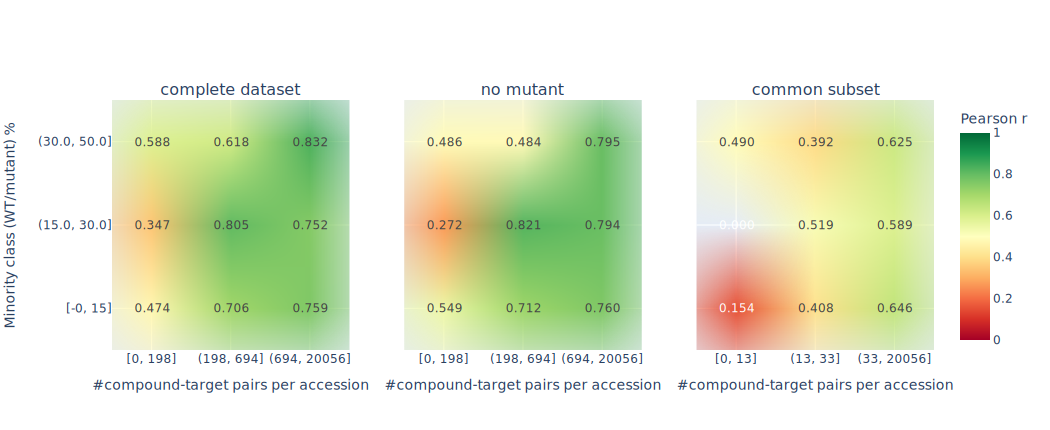

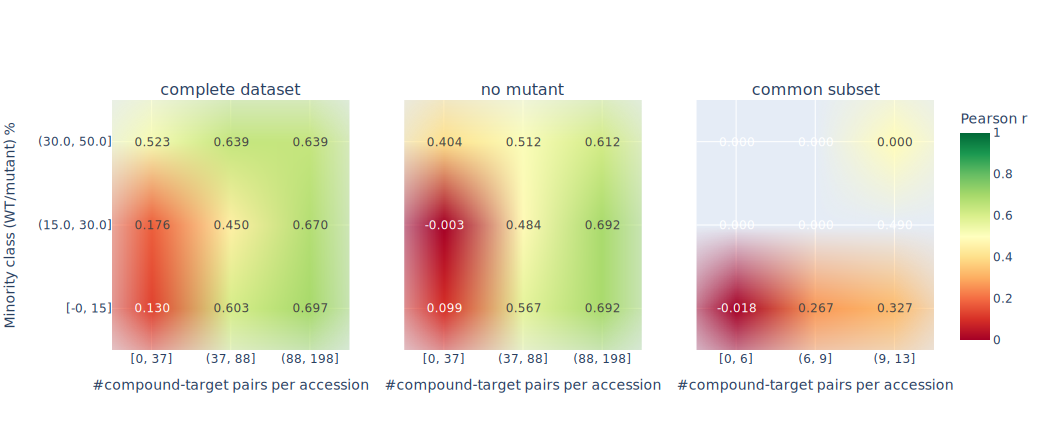

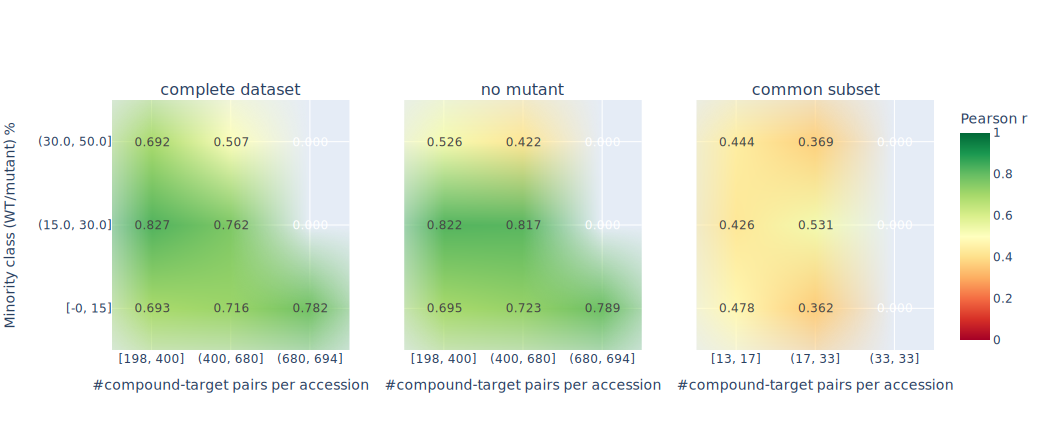

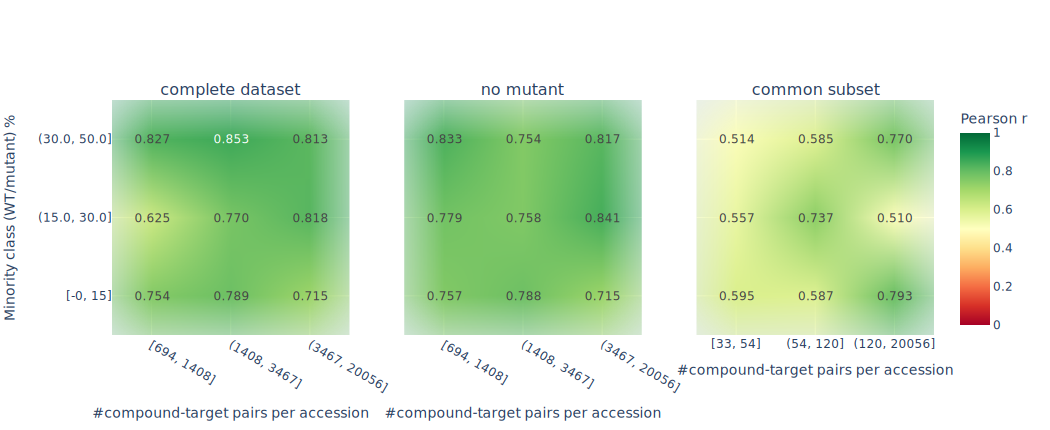

In [76]:
if USE_PERCENTILE:
    #Nums  = [0, 33.34%], (33.34%, 66.67%], (66.67%, 100.0%]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_avg_bar_chart((0, num_33_percentile, num_66_percentile, 20056), (0, 15, 30, 50),
                         (0, num_33_percentile_common, num_66_percentile_common, 20056), (0, 15, 30, 50)
                 ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapspercentiles.svg'), engine='orca')
    #Nums  = [0, 11.12%], (11.12%, 22.23%], (22.23%, 33.34%]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_avg_bar_chart((0, num_11_percentile, num_22_percentile, num_33_percentile), (0, 15, 30, 50),
                         (0, num_11_percentile_common, num_22_percentile_common, num_33_percentile_common), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapspercentiles_0-33-zoomin.svg'), engine='orca')
    #Nums  = [33.34, 44.45%], (44.45%, 55.56%], (55.56%, 66.67%]
    #Ratios= [0, 16.67%],     (16,67%, 33.34%], (33.34%, 50.0%]
    update_avg_bar_chart((num_33_percentile, num_44_percentile, num_55_percentile, num_66_percentile), (0, 15, 30, 50),
                         (num_33_percentile_common, num_44_percentile_common, num_55_percentile_common, num_66_percentile_common), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapspercentiles_33-66-zoomin.svg'), engine='orca') 
    #Nums  = [66.67, 77.78%], (77.78%, 88.89%], (88.89%, 100.0%]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_avg_bar_chart((num_66_percentile, num_77_percentile, num_88_percentile, subplot1_data.num_datapoints_total.max()), (0, 15, 30, 50),
                         (num_66_percentile_common, num_77_percentile_common, num_88_percentile_common, subplot1_data.num_datapoints_total.max()), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapspercentiles_66-100-zoomin.svg'), engine='orca')
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapspercentiles.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapspercentiles_0-33-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapspercentiles_33-66-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapspercentiles_66-100-zoomin.svg')))
else:
    #Nums  = [0, 1_000],  (1_000, 10_000],  (10_000, 75_211]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_avg_bar_chart((0, 1_000, 10_000, 20056), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50),
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapsnum-0-20k.svg'), engine='orca')
    #Nums  = [0, 100],    (100, 500],       (500, 1_000]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_avg_bar_chart((0, 100, 500, 1000), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50),
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapsnum-0k-1k-zoomin.svg'), engine='orca')
    #Nums  = [1_000, 2_000],  (2_000, 5_000],  (5_000, 10_000]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_avg_bar_chart((1_000, 2_000, 5_000, 10_000), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50),
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapsnum-1k-10k-zoomin.svg'), engine='orca')
    #Nums  = [10_000, 15_000],  (15_000, 50_000],  (50_000, 75_211]
    #Ratios= [0, 16.67%],       (16,67%, 33.34%],  (33.34%, 50.0%]
    update_avg_bar_chart((10_000, 14000, 18000, 20056), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50),
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapsnum-10k-20k-zoomin.svg'), engine='orca')
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapsnum-0-20k.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapsnum-0k-1k-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapsnum-1k-10k-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_avg_heatmapsnum-10k-20k-zoomin.svg')))

R² for #compound target pairs < 1000

In [19]:
(data[(data.crossval == 'random') & (data.folds == 'Mean') & ~((data.subset == 'common') & ~data.contains_mutants)]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]).merge(data_counts, on='accession')
                 .drop(columns=['accession'])).query('num_datapoints_total < 1000')['Pearson r'].mean()

0.5274634684093057

In [20]:
(data[(data.crossval == 'random') & (data.folds == 'Mean') & ~((data.subset == 'common') & ~data.contains_mutants)]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]).merge(data_counts, on='accession')
                 .drop(columns=['accession'])).query('1000 <= num_datapoints_total < 10_000')['Pearson r'].mean()

0.6950122606865566

In [21]:
(data[(data.crossval == 'random') & (data.folds == 'Mean') & ~((data.subset == 'common') & ~data.contains_mutants)]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]).merge(data_counts, on='accession')
                 .drop(columns=['accession'])).query('num_datapoints_total >= 10_000')['Pearson r'].mean()

0.7193234512801298

In [22]:
(data[(data.crossval == 'random') & (data.folds == 'Mean')]
 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession', 'contains_mutants', 'subset']])
 .merge(data_counts.query('num_datapoints_total >= 10_000').query('minority_percentage < 15'))
 )

,Pearson r,accession,subset,contains_mutants,modeltype,num_datapoints_total,num_datapoints_WT,num_datapoints_mutants,datapoints_WT_percentage,minority_percentage
0,0.686389,P42336,common,False,PCM,14050.0,13802.0,248.0,98.234875,1.765125
1,0.970715,P42336,common,True,PCM,14050.0,13802.0,248.0,98.234875,1.765125
2,0.842513,P42336,complete,False,PCM,14050.0,13802.0,248.0,98.234875,1.765125
3,0.846230,P42336,complete,True,PCM,14050.0,13802.0,248.0,98.234875,1.765125
4,0.686389,P42336,common,False,QSAR,14050.0,13802.0,248.0,98.234875,1.765125
5,0.972541,P42336,common,True,QSAR,14050.0,13802.0,248.0,98.234875,1.765125
6,0.842513,P42336,complete,False,QSAR,14050.0,13802.0,248.0,98.234875,1.765125
7,0.850579,P42336,complete,True,QSAR,14050.0,13802.0,248.0,98.234875,1.765125
8,0.373305,P00352,complete,False,PCM,20056.0,20054.0,2.0,99.990028,0.009972
9,0.365299,P00352,complete,True,PCM,20056.0,20054.0,2.0,99.990028,0.009972


In [82]:
(data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & ~data.contains_mutants]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]).merge(data_counts, on='accession')
                 .drop(columns=['accession'])).query('num_datapoints_total <= 198')['Pearson r'].mean()

0.46289064341665076

In [83]:
(data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & ~data.contains_mutants]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]).merge(data_counts, on='accession')
                 .drop(columns=['accession'])).query('198 < num_datapoints_total <= 694')['Pearson r'].mean()

0.700994829584767

In [84]:
(data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & ~data.contains_mutants]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]).merge(data_counts, on='accession')
                 .drop(columns=['accession'])).query('694 < num_datapoints_total')['Pearson r'].mean()

0.7631738233928057

In [85]:
((data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & data.contains_mutants]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]).merge(data_counts, on='accession')
                 .drop(columns=['accession'])).query('minority_percentage > 30 and modeltype == "PCM"')['Pearson r'].mean()
-
(data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & data.contains_mutants]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]).merge(data_counts, on='accession')
                 .drop(columns=['accession'])).query('minority_percentage > 30 and modeltype == "QSAR"')['Pearson r'].mean())

0.057344415339005916

In [86]:
((data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & data.contains_mutants]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]).merge(data_counts, on='accession')
                 .drop(columns=['accession'])).query('minority_percentage <= 30 and modeltype == "PCM"')['Pearson r'].mean()
-
(data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & data.contains_mutants]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]).merge(data_counts, on='accession')
                 .drop(columns=['accession'])).query('minority_percentage <= 30 and modeltype == "QSAR"')['Pearson r'].mean())

0.014858765538807828

In [109]:
(subplot3_data[(subplot3_data.minority_percentage > 30)]
 ['Pearson r']
 .mean()
)

0.5129136192690376

In [110]:
(subplot3_data[(subplot3_data.num_common_datapoints_total <= 33)]
 ['Pearson r']
 .mean()
)

0.3028435821445919

In [111]:
(subplot3_data[(subplot3_data.num_common_datapoints_total > 33)]
 ['Pearson r']
 .mean()
)

0.621251998147438

In [113]:
(subplot3_data
 .sort_values(['accession', 'modeltype'], ascending=[True, False])
 .reset_index(drop=True)
 ['Pearson r']
 .diff()
 [1::2]
 .mean()
)

0.16348441713318368

In [ ]:
(subplot3_data[(subplot3_data.num_common_datapoints_total <= 33)]
 .sort_values(['accession', 'modeltype'], ascending=[True, False])
 .reset_index(drop=True)
 ['Pearson r']
 .diff()
 [1::2]
 .mean()
)

In [26]:
pd.concat([pd.cut(subplot2_data.sort_values(by='accession').drop(columns=['Pearson r', 'contains_mutants'])[1::2]['minority_percentage'], [-1, 30, 50]),
           subplot2_data.sort_values(by='accession').query('contains_mutants')['Pearson r'].reset_index(drop=True) - subplot2_data.sort_values(by='accession').query('not contains_mutants')['Pearson r'].reset_index(drop=True)
           ],
          axis=1).groupby('minority_percentage').agg('mean')

,Pearson r
minority_percentage,
"(-1, 30]",0.003285
"(30, 50]",0.049191


In [27]:
subplot2_data.sort_values(by='accession')

,Pearson r,accession,contains_mutants,num_datapoints_total,num_datapoints_WT,num_datapoints_mutants,datapoints_WT_percentage,minority_percentage
0,0.866612,A0A045ISB3,True,261.0,245.0,16.0,93.869732,6.130268
1,0.917751,A0A045ISB3,False,261.0,245.0,16.0,93.869732,6.130268
2,0.037062,A2RI47,True,23.0,17.0,6.0,73.913043,26.086957
3,-0.148715,A2RI47,False,23.0,17.0,6.0,73.913043,26.086957
4,0.824915,A3EZI9,True,794.0,673.0,121.0,84.760705,15.239295
...,...,...,...,...,...,...,...,...
503,0.667533,Q9Y2R2,False,279.0,272.0,7.0,97.491039,2.508961
504,0.574212,Q9Y5X5,True,129.0,116.0,13.0,89.922481,10.077519
505,0.634026,Q9Y5X5,False,129.0,116.0,13.0,89.922481,10.077519
509,0.878640,Q9YQ12,False,1168.0,1092.0,76.0,93.493151,6.506849


In [28]:
(subplot2_data.sort_values(by='accession').query('contains_mutants')['Pearson r'].reset_index(drop=True) - subplot2_data.sort_values(by='accession').query('~contains_mutants')['Pearson r'].reset_index(drop=True))

0     -0.051139
1      0.185776
2     -0.016673
3      0.042106
4     -0.751997
         ...   
303    0.002481
304   -0.001304
305   -0.018965
306   -0.059814
307   -0.015758
Name: Pearson r, Length: 308, dtype: float64

In [29]:
pd.concat([subplot2_data.sort_values(by='accession').drop(columns=['Pearson r', 'contains_mutants'])[1::2],
           (subplot2_data.sort_values(by='accession').query('contains_mutants')['Pearson r'].reset_index(drop=True) - subplot2_data.sort_values(by='accession').query('~contains_mutants')['Pearson r'].reset_index(drop=True))#subplot2_data.sort_values(by='accession')['Pearson r'].diff(periods=1)[1::2]
           ],
          axis=1).query('minority_percentage > 30')['Pearson r'].mean()

0.049190845221482246

In [30]:
app = Dash(__name__)

app.layout = html.Div([
                       dcc.Graph(id="heatmap-graph"),
                       html.P("#datapoints:"),
                       dcc.RangeSlider(
                           id='heatmap-x-range-slider',
                           min=subplot1_data.num_datapoints_total.min(),
                           max=subplot1_data.num_datapoints_total.max(),
                           step=1000,
                           value=[subplot1_data.num_datapoints_total.min(), 1_000, 10_000, subplot1_data.num_datapoints_total.max()]
                           ),
                       html.P("balance ratio:"),
                       dcc.RangeSlider(
                            id='heatmap-y-range-slider',
                            min=0, max=50, step=1,
                           value=[0, 15, 30, 50]
                            ),
                       html.P("num datapoints (common)"),
                       dcc.RangeSlider(
                            id='heatmap-binscommon-slider',
                            min=subplot3_data.num_common_datapoints_total.min(),
                            max=subplot3_data.num_common_datapoints_total.max(),
                            step=10,
                            value=[subplot3_data.num_common_datapoints_total.min(), 100, 500, subplot3_data.num_common_datapoints_total.max()]
                            ),
                       html.P("balance ratio (common)"),
                       dcc.RangeSlider(
                            id='heatmap-balancecommon-slider',
                            min=0, max=50, step=1,
                            value=[0, 15, 30, 50]
                            ),
                       ])


@app.callback(
    Output("heatmap-graph", "figure"),
    [Input("heatmap-x-range-slider", "value"),
     Input("heatmap-y-range-slider", "value"),
     Input("heatmap-binscommon-slider", "value"),
     Input("heatmap-balancecommon-slider", "value"),
     ])
def update_count_bar_chart(slider_x, slider_y, slider_x_common, slider_y_common):
    # Obtain data
    global subplot2_data, subplot3_data, subplot4_data
    subplot_data1 = subplot1_data.copy().drop_duplicates(subset=['accession']).drop(columns='accession')
    subplot_data2 = subplot4_data.copy().drop_duplicates(subset=['accession']).drop(columns='accession')
    subplot_data3 = subplot3_data.copy().drop_duplicates(subset=['accession']).drop(columns='accession')
    # Slider values
    min_x, low_x, high_x, max_x = slider_x
    min_y, low_y, high_y, max_y = slider_y
    
    min_x_common, low_x_common, high_x_common, max_x_common = slider_x_common
    min_y_common, low_y_common, high_y_common, max_y_common = slider_y_common
       
    # Obtain categories
    intervals_num_datapoints = [(min_x - 0.1, low_x),
                            (low_x, high_x),
                            (high_x, max_x)]
    intervals_ratio = [(min_y - 0.1, low_y),
                       (low_y, high_y),
                       (high_y, max_y)]
    
    intervals_num_datapoints_common = [(min_x_common - 0.1, low_x_common),
                            (low_x_common, high_x_common),
                            (high_x_common, max_x_common)]
    intervals_ratio_common = [(min_y_common - 0.1, low_y_common),
                       (low_y_common, high_y_common),
                       (high_y_common, max_y_common)]
    
    num_intervals = pd.IntervalIndex.from_tuples(intervals_num_datapoints)
    ratio_intervals = pd.IntervalIndex.from_tuples(intervals_ratio)
    
    num_intervals_common = pd.IntervalIndex.from_tuples(intervals_num_datapoints_common)
    ratio_intervals_common = pd.IntervalIndex.from_tuples(intervals_ratio_common)

    # Put data in bins
    subplot_data1['num_bins'] = pd.cut(subplot_data1.num_datapoints_total.values, num_intervals)
    subplot_data2['num_bins'] = pd.cut(subplot_data2.num_datapoints_WT.values, num_intervals)
    subplot_data3['num_bins'] = pd.cut(subplot_data3.num_common_datapoints_total.values, num_intervals_common)
    subplot_data1['ratio_bins'] = pd.cut(subplot_data1.minority_percentage.values, ratio_intervals)
    subplot_data2['ratio_bins'] = pd.cut(subplot_data2.minority_percentage.values, ratio_intervals)
    subplot_data3['ratio_bins'] = pd.cut(subplot_data3.minority_percentage.values, ratio_intervals_common)
    
    # Rename intervals
    subplot_data1['num_bins'] = subplot_data1['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data2['num_bins'] = subplot_data2['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data3['num_bins'] = subplot_data3['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    # Clean up columns
    subplot_data1 = subplot_data1.drop(columns=['num_datapoints_total', 'minority_percentage'])
    subplot_data2 = subplot_data2.drop(columns=['num_datapoints_WT', 'minority_percentage'])
    subplot_data3 = subplot_data3.drop(columns=['num_common_datapoints_total', 'minority_percentage'])
    
    # Remove nan bins
    subplot_data1 = subplot_data1[subplot_data1.num_bins != 'nan']
    subplot_data2 = subplot_data2[subplot_data2.num_bins != 'nan']
    subplot_data3 = subplot_data3[subplot_data3.num_bins != 'nan']
    
    # Group by, pivot and obtain difference
    subplot_data1 = subplot_data1.groupby(['modeltype', 'num_bins', 'ratio_bins']).agg('count').reset_index()
    subplot_data1 = subplot_data1.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['modeltype', 'ratio_bins']).reset_index()
    subplot_data1 = subplot_data1.drop(columns='modeltype').groupby('ratio_bins').agg('sum')
    # subplot_data1
    
    subplot_data2 = subplot_data2.groupby(['modeltype', 'num_bins', 'ratio_bins']).agg('count').reset_index()
    subplot_data2 = subplot_data2.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['modeltype', 'ratio_bins']).reset_index()
    subplot_data2 = subplot_data2.drop(columns='modeltype').groupby('ratio_bins').agg('sum')
    # subplot_data2
    
    subplot_data3 = subplot_data3.groupby(['modeltype', 'num_bins', 'ratio_bins']).agg('count').reset_index()
    subplot_data3 = subplot_data3.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['modeltype', 'ratio_bins']).reset_index()
    subplot_data3 = subplot_data3.drop(columns='modeltype').groupby('ratio_bins').agg('sum')
    # Melt dataframes 
    subplot_data1 = pd.melt(subplot_data1.reset_index(), id_vars=['ratio_bins']) 
    subplot_data2 = pd.melt(subplot_data2.reset_index(), id_vars=['ratio_bins'])
    subplot_data3 = pd.melt(subplot_data3.reset_index(), id_vars=['ratio_bins'])

    # Rename intervals
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[0]): f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]'})
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[1]): f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]'})
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[2]): f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'[{intervals_ratio[0][0]:.0f}, {intervals_ratio[0][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[1][0]:.0f}, {intervals_ratio[1][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[2][0]:.0f}, {intervals_ratio[2][1]:.0f}]'})
    
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[0]): f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]'})
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[1]): f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]'})
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[2]): f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'[{intervals_ratio[0][0]:.0f}, {intervals_ratio[0][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[1][0]:.0f}, {intervals_ratio[1][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[2][0]:.0f}, {intervals_ratio[2][1]:.0f}]'})
    
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals_common[0]): f'[{intervals_num_datapoints_common[0][0] + 0.1:.0f}, {intervals_num_datapoints_common[1][0]:.0f}]'})
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals_common[1]): f'({intervals_num_datapoints_common[1][0]:.0f}, {intervals_num_datapoints_common[1][1]:.0f}]'})
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals_common[2]): f'({intervals_num_datapoints_common[2][0]:.0f}, {intervals_num_datapoints_common[2][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals_common[0]): f'[{intervals_ratio_common[0][0]:.0f}, {intervals_ratio_common[0][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals_common[0]): f'({intervals_ratio_common[1][0]:.0f}, {intervals_ratio_common[1][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals_common[0]): f'({intervals_ratio_common[2][0]:.0f}, {intervals_ratio_common[2][1]:.0f}]'})
        
    # Figure
    fig = make_subplots(rows=1, cols=3,
                        shared_yaxes=True,
                        subplot_titles=['complete dataset', 'no mutant', 'common subset'],
                       )
    
    fig.add_trace(go.Heatmap(x=subplot_data1.num_bins, y=subplot_data1.ratio_bins, z=subplot_data1.value, 
                             zmin=0, zmax=200,
                             showscale=False,
                             colorscale='RdYlGn',
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Heatmap(x=subplot_data2.num_bins, y=subplot_data2.ratio_bins, z=subplot_data2.value,
                             zmin=0, zmax=200,
                             showscale=False,
                             colorscale='RdYlGn',
                             ),
                  row=1, col=2)
    
    fig.add_trace(go.Heatmap(x=subplot_data3.num_bins, y=subplot_data3.ratio_bins, z=subplot_data3.value,
                             zmin=0, zmax=200,
                             colorscale='RdYlGn',
                             colorbar={"title": 'Pearson r'}
                             ),
                  row=1, col=3)
    # Add title
    fig.update_layout({'xaxis': {'categoryarray': [f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'xaxis2': {'categoryarray': [f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'xaxis3': {'categoryarray': [f'[{intervals_num_datapoints_common[0][0] + 0.1:.0f}, {intervals_num_datapoints_common[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints_common[1][0]:.0f}, {intervals_num_datapoints_common[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints_common[2][0]:.0f}, {intervals_num_datapoints_common[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'yaxis': {'title': 'Minority class (WT/mutant) %'},
                       })


    fig.update_traces(row=1, col=1, text=subplot_data1.value, texttemplate="%{text:.0f}", hovertemplate=None)
    fig.update_traces(row=1, col=2, text=subplot_data2.value, texttemplate="%{text:.0f}", hovertemplate=None)
    fig.update_traces(row=1, col=3, text=subplot_data3.value, texttemplate="%{text:.0f}", hovertemplate=None)

    fig.update_layout(autosize=False, width=1050, height=430)

        
    return fig

if __name__ == '__main__':
    app.run_server(debug=False)

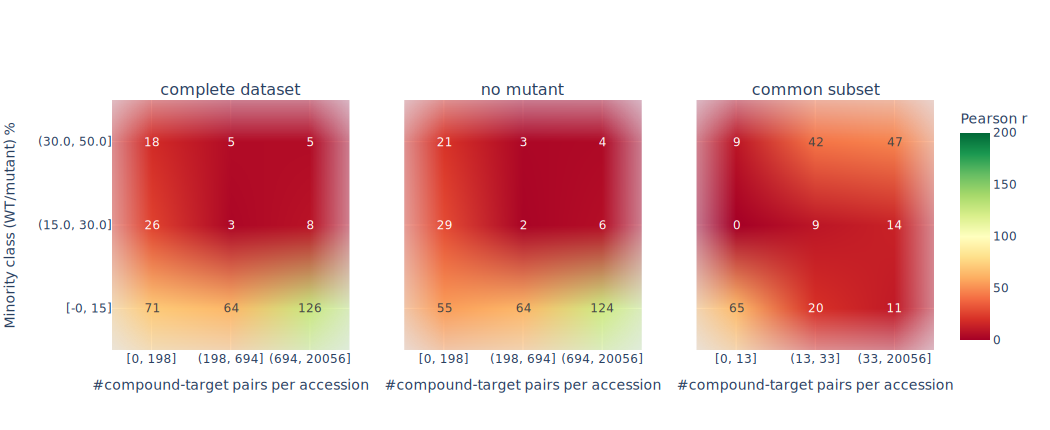

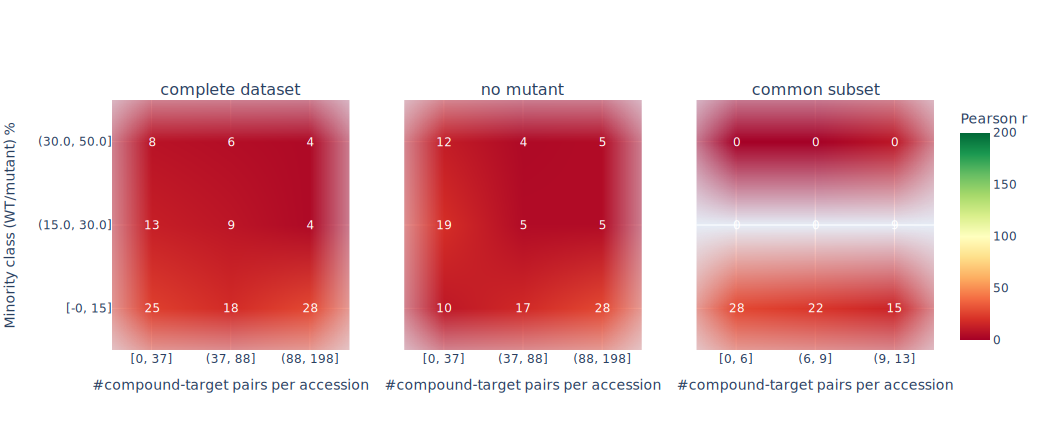

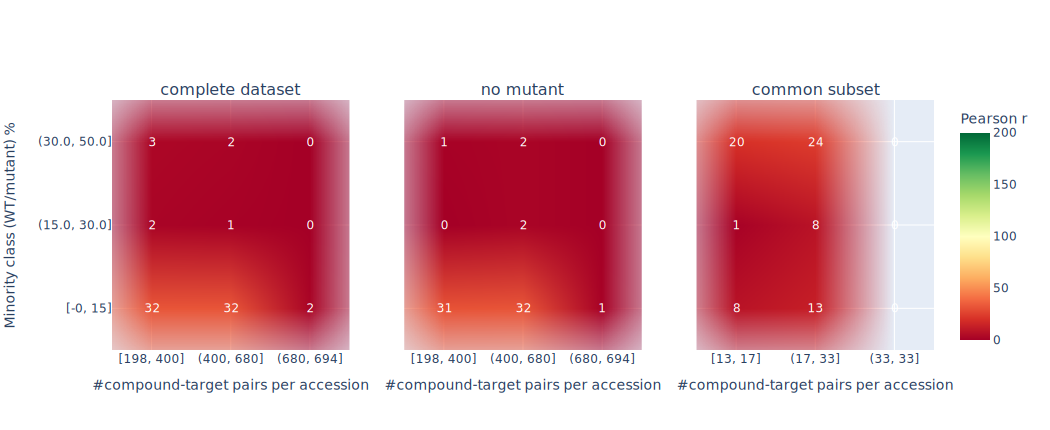

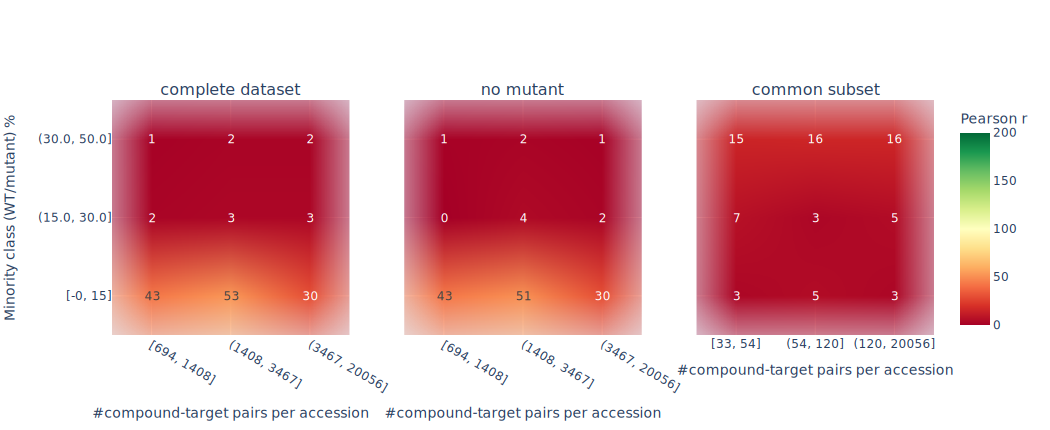

In [31]:
if USE_PERCENTILE:
    #Nums  = [0, 33.34%], (33.34%, 66.67%], (66.67%, 100.0%]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_count_bar_chart((0, num_33_percentile, num_66_percentile, 20056), (0, 15, 30, 50),
                         (0, num_33_percentile_common, num_66_percentile_common, 20056), (0, 15, 30, 50)
                 ).write_image(os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapspercentiles.svg'), engine='orca')
    #Nums  = [0, 11.12%], (11.12%, 22.23%], (22.23%, 33.34%]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_count_bar_chart((0, num_11_percentile, num_22_percentile, num_33_percentile), (0, 15, 30, 50),
                         (0, num_11_percentile_common, num_22_percentile_common, num_33_percentile_common), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapspercentiles_0-33-zoomin.svg'), engine='orca')
    #Nums  = [33.34, 44.45%], (44.45%, 55.56%], (55.56%, 66.67%]
    #Ratios= [0, 16.67%],     (16,67%, 33.34%], (33.34%, 50.0%]
    update_count_bar_chart((num_33_percentile, num_44_percentile, num_55_percentile, num_66_percentile), (0, 15, 30, 50),
                         (num_33_percentile_common, num_44_percentile_common, num_55_percentile_common, num_66_percentile_common), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapspercentiles_33-66-zoomin.svg'), engine='orca') 
    #Nums  = [66.67, 77.78%], (77.78%, 88.89%], (88.89%, 100.0%]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_count_bar_chart((num_66_percentile, num_77_percentile, num_88_percentile, subplot1_data.num_datapoints_total.max()), (0, 15, 30, 50),
                         (num_66_percentile_common, num_77_percentile_common, num_88_percentile_common, subplot1_data.num_datapoints_total.max()), (0, 15, 30, 50)
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapspercentiles_66-100-zoomin.svg'), engine='orca')
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapspercentiles.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapspercentiles_0-33-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapspercentiles_33-66-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapspercentiles_66-100-zoomin.svg')))
else:
    #Nums  = [0, 1_000],  (1_000, 10_000],  (10_000, 75_211]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_count_bar_chart((0, 1_000, 10_000, 20056), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50),
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapsnum-0-20k.svg'), engine='orca')
    #Nums  = [0, 100],    (100, 500],       (500, 1_000]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_count_bar_chart((0, 100, 500, 1000), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50),
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapsnum-0k-1k-zoomin.svg'), engine='orca')
    #Nums  = [1_000, 2_000],  (2_000, 5_000],  (5_000, 10_000]
    #Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
    update_count_bar_chart((1_000, 2_000, 5_000, 10_000), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50),
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapsnum-1k-10k-zoomin.svg'), engine='orca')
    #Nums  = [10_000, 15_000],  (15_000, 50_000],  (50_000, 75_211]
    #Ratios= [0, 16.67%],       (16,67%, 33.34%],  (33.34%, 50.0%]
    update_count_bar_chart((10_000, 14000, 18000, 20056), (0, 15, 30, 50), (0, 100, 500, 2854), (0, 15, 30, 50),
                     ).write_image(os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapsnum-10k-20k-zoomin.svg'), engine='orca')
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapsnum-0-20k.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapsnum-0k-1k-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapsnum-1k-10k-zoomin.svg')))
    display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/counts_heatmapsnum-10k-20k-zoomin.svg')))